# Random Bayesian Network

## Baseline network to compare performance

In [1]:
import pgmpy
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import sys
sys.path.insert(0,"..")
from Data.DataPreprocessing import DataPreprocessing as myData
from pgmpy import estimators
from pgmpy.inference import VariableElimination

c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data importing and preprocessing

In [2]:
loaded_data = myData.load_data()

#display(loaded_data)
data = myData.preprocess_data(loaded_data)
train_data, validation_data, test_data = myData.split_data(data,num_rows = 1000)

feature_states = myData.get_feature_states(data)
display(data)

c:\Users\zachs\Documents\CSHons\ResearchReport\Research_Code\Honours-Research\Baseline\..\Data\DataPreprocessing.py:14: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/accepted_2007_to_2018Q4.csv", engine='c')
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *ar

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,"(961.0, 8800.0]",36 months,"(10.446, 15.582]","(5.898, 350.054]",C,10+ years,MORTGAGE,0.0,Not Verified,2015,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,N,Cash,N
1,"(24400.0, 32200.0]",36 months,"(10.446, 15.582]","(692.498, 1034.942]",C,10+ years,MORTGAGE,0.0,Not Verified,2015,...,0.0,4.0,0.0,0.0,0.0,0.0,2.0,N,Cash,N
2,"(16600.0, 24400.0]",60 months,"(10.446, 15.582]","(350.054, 692.498]",B,10+ years,MORTGAGE,0.0,Not Verified,2015,...,0.0,4.0,2.0,0.0,0.0,0.0,0.0,N,Cash,N
4,"(8800.0, 16600.0]",60 months,"(20.718, 25.854]","(5.898, 350.054]",F,3 years,MORTGAGE,1.0,Source Verified,2015,...,1.0,4.0,2.0,0.0,0.0,1.0,1.0,N,Cash,N
5,"(8800.0, 16600.0]",36 months,"(10.446, 15.582]","(350.054, 692.498]",C,4 years,RENT,0.0,Source Verified,2015,...,0.0,4.0,4.0,0.0,0.0,0.0,0.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,"(16600.0, 24400.0]",60 months,"(5.284, 10.446]","(350.054, 692.498]",B,5 years,OWN,1.0,Not Verified,2016,...,0.0,4.0,1.0,0.0,0.0,1.0,0.0,N,Cash,N
2260690,"(24400.0, 32200.0]",60 months,"(10.446, 15.582]","(350.054, 692.498]",C,9 years,MORTGAGE,1.0,Not Verified,2016,...,0.0,4.0,2.0,0.0,0.0,2.0,2.0,N,Cash,N
2260691,"(24400.0, 32200.0]",60 months,"(10.446, 15.582]","(692.498, 1034.942]",C,3 years,MORTGAGE,1.0,Source Verified,2016,...,0.0,4.0,0.0,0.0,0.0,2.0,0.0,N,Cash,N
2260692,"(8800.0, 16600.0]",60 months,"(10.446, 15.582]","(350.054, 692.498]",C,10+ years,RENT,1.0,Not Verified,2016,...,0.0,3.0,2.0,1.0,0.0,1.0,0.0,N,Cash,N


### Create Random Network

+------------------+----------+
| term( 36 months) | 0.638138 |
+------------------+----------+
| term( 60 months) | 0.361862 |
+------------------+----------+
+----------------------------+-----------+
| int_rate((10.446, 15.582]) | 0.270333  |
+----------------------------+-----------+
| int_rate((20.718, 25.854]) | 0.153294  |
+----------------------------+-----------+
| int_rate((5.284, 10.446])  | 0.299897  |
+----------------------------+-----------+
| int_rate((15.582, 20.718]) | 0.243581  |
+----------------------------+-----------+
| int_rate((25.854, 30.99])  | 0.0328949 |
+----------------------------+-----------+
+-----------------------------------+-----------+
| installment((5.898, 350.054])     | 0.270333  |
+-----------------------------------+-----------+
| installment((692.498, 1034.942])  | 0.153294  |
+-----------------------------------+-----------+
| installment((350.054, 692.498])   | 0.299897  |
+-----------------------------------+-----------+
| installment((10

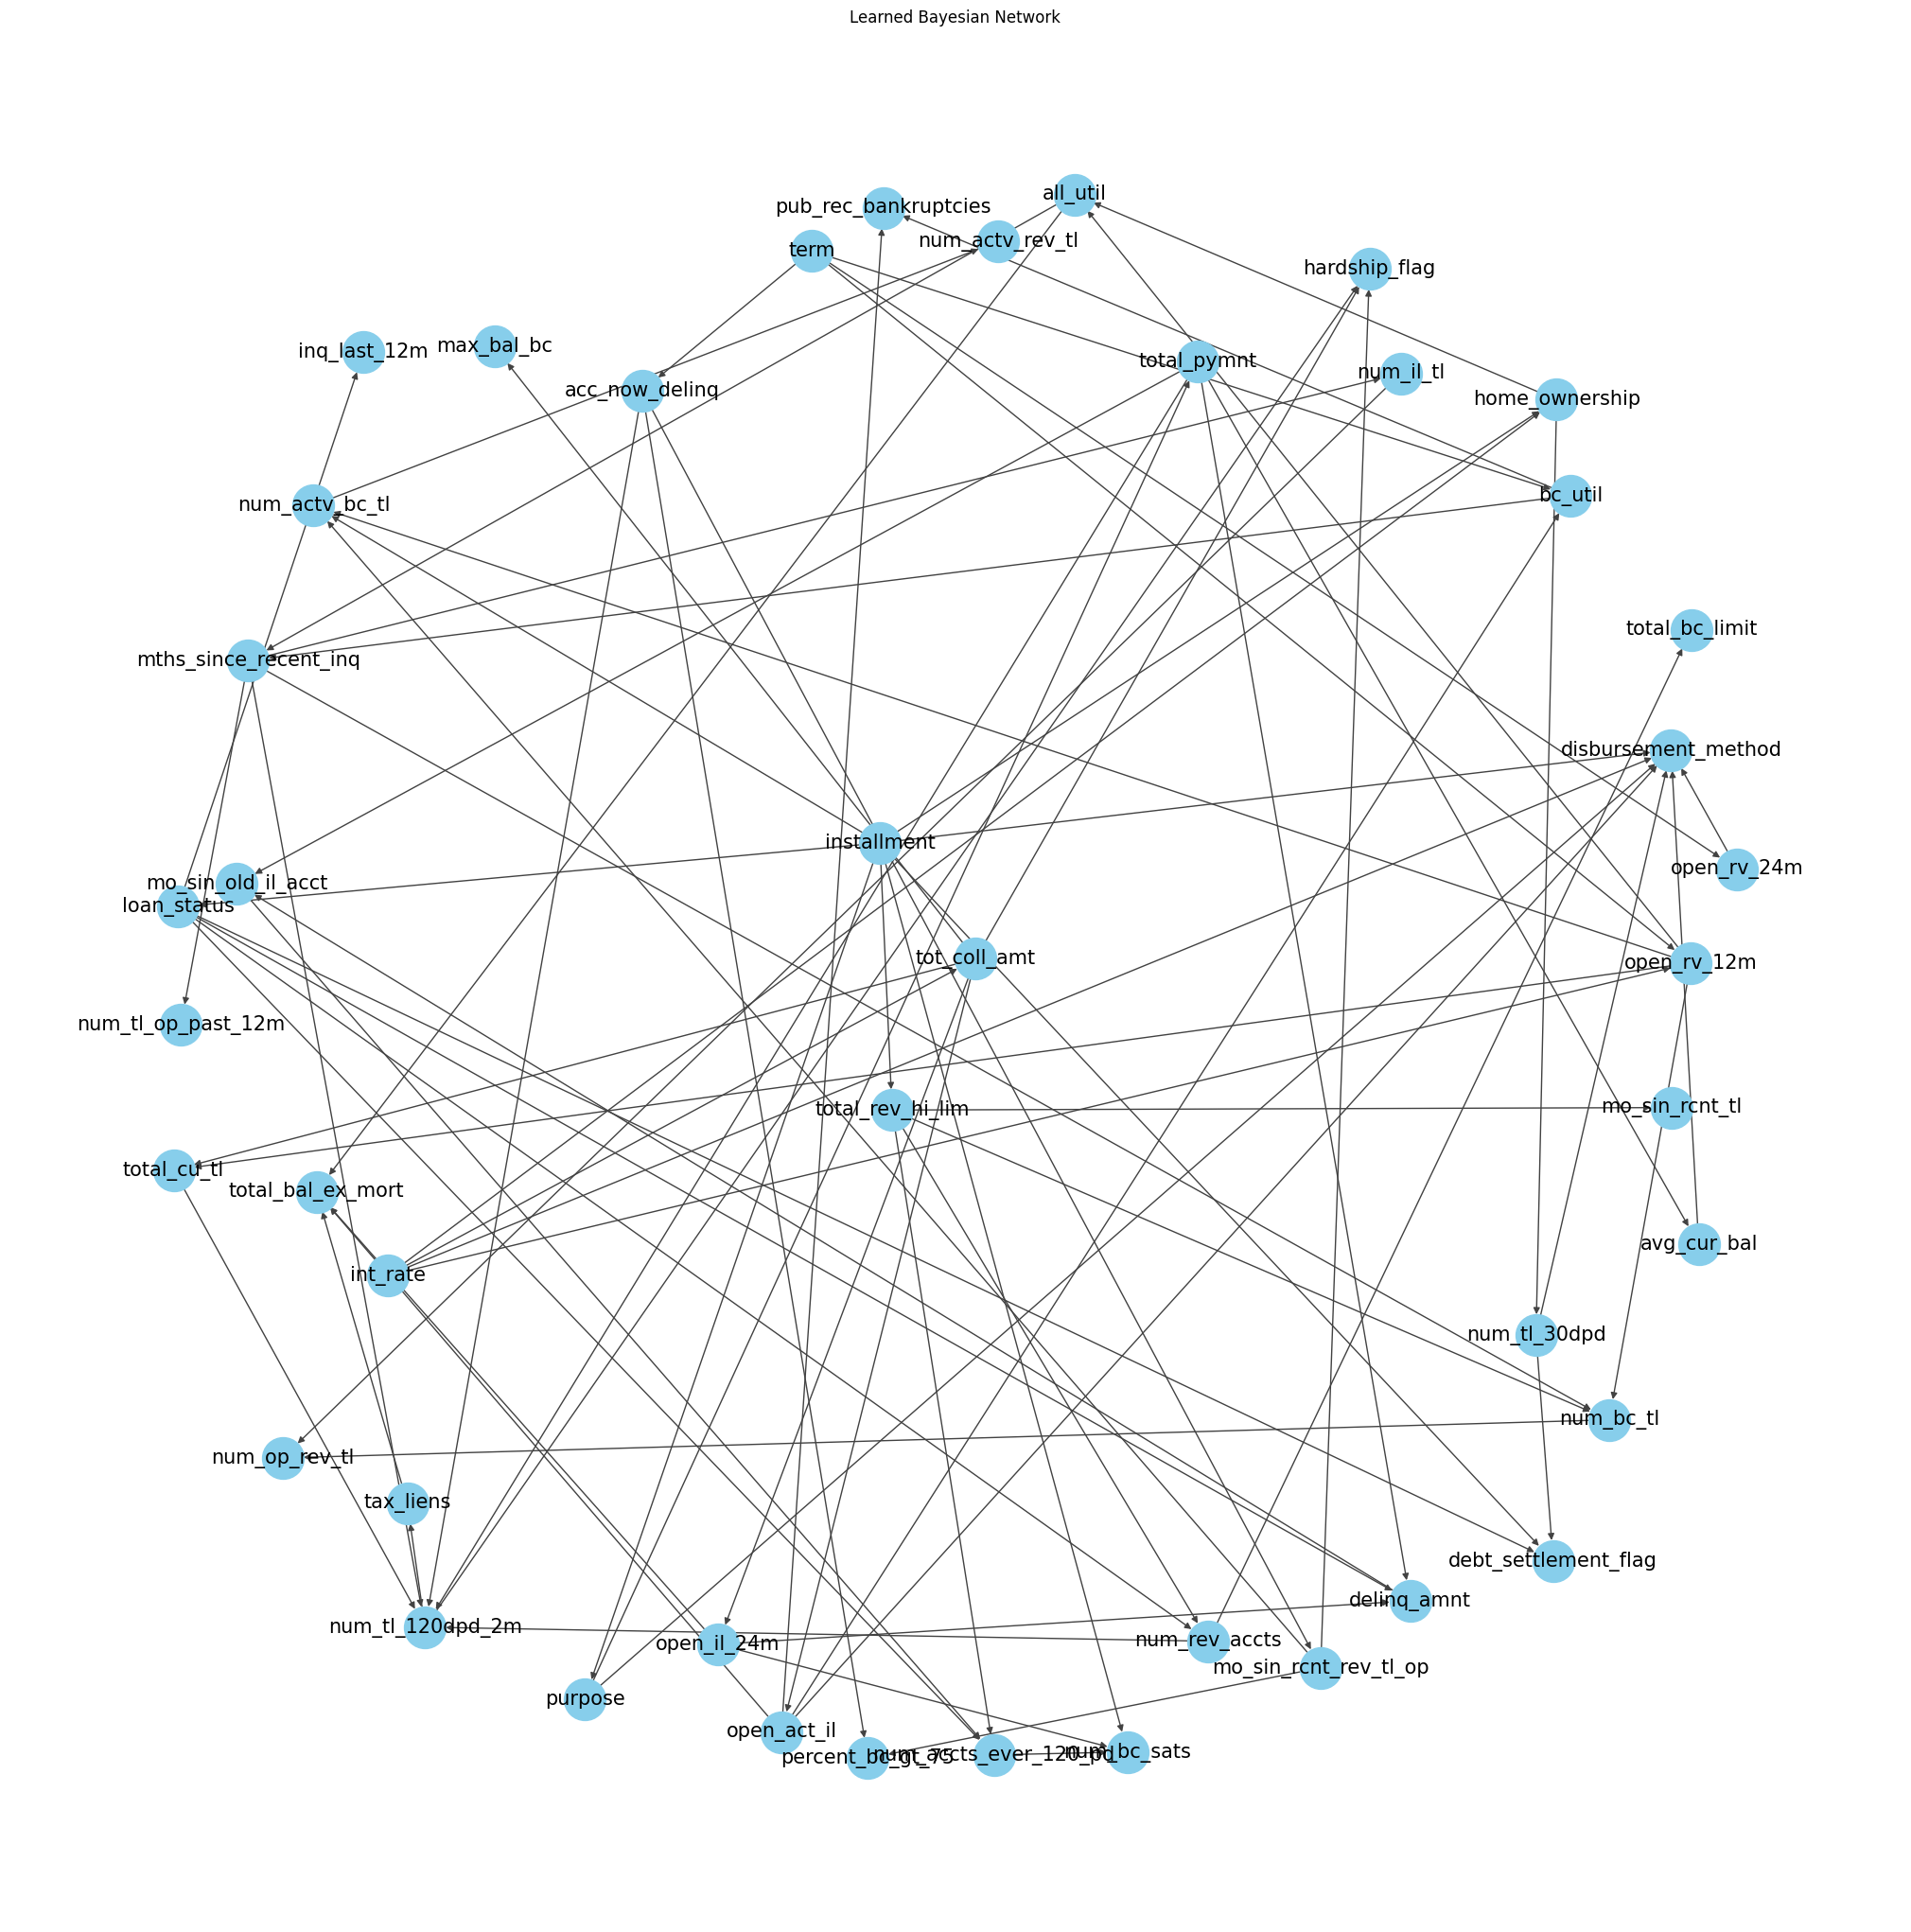

In [3]:
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

Random_BN = BayesianNetwork()
Random_Dag = DAG.get_random(n_nodes = len(train_data.columns.to_list()), node_names=train_data.columns.to_list(), edge_prob=0.06)
Random_BN.add_nodes_from(train_data.columns.to_list())
Random_BN.add_edges_from(Random_Dag.edges())

active_trail_nodes = Random_BN.active_trail_nodes(['loan_status',"int_rate","term","installment"])
active_trail_nodes_list = list(active_trail_nodes['loan_status'])
active_trail_nodes_list.extend(active_trail_nodes['int_rate'])
active_trail_nodes_list.extend(active_trail_nodes['term'])
active_trail_nodes_list.extend(active_trail_nodes['installment'])
original_nodes = list(Random_BN.nodes())
for node in original_nodes:
    if node not in active_trail_nodes_list:
        Random_BN.remove_node(node)
        
        
CPDs_list = []
cardinality_dict = {key: len(feature_states[key]) for key in feature_states.keys()}
for node in Random_BN.nodes():
    Random_CPD = TabularCPD.get_random(variable= node, evidence = Random_BN.get_parents(node), cardinality = cardinality_dict, state_names = feature_states)
    Random_BN.add_cpds(Random_CPD)
    print(Random_CPD)
    
    

print(Random_BN.states)
#feature_states
nx_graph = nx.DiGraph(Random_BN.edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(20, 20))
nx.draw(nx_graph, pos, with_labels=True, node_size=1000, node_color = 'skyblue', edge_color='#424242',font_size=15,font_color='black')
plt.title('Learned Bayesian Network')
plt.show()


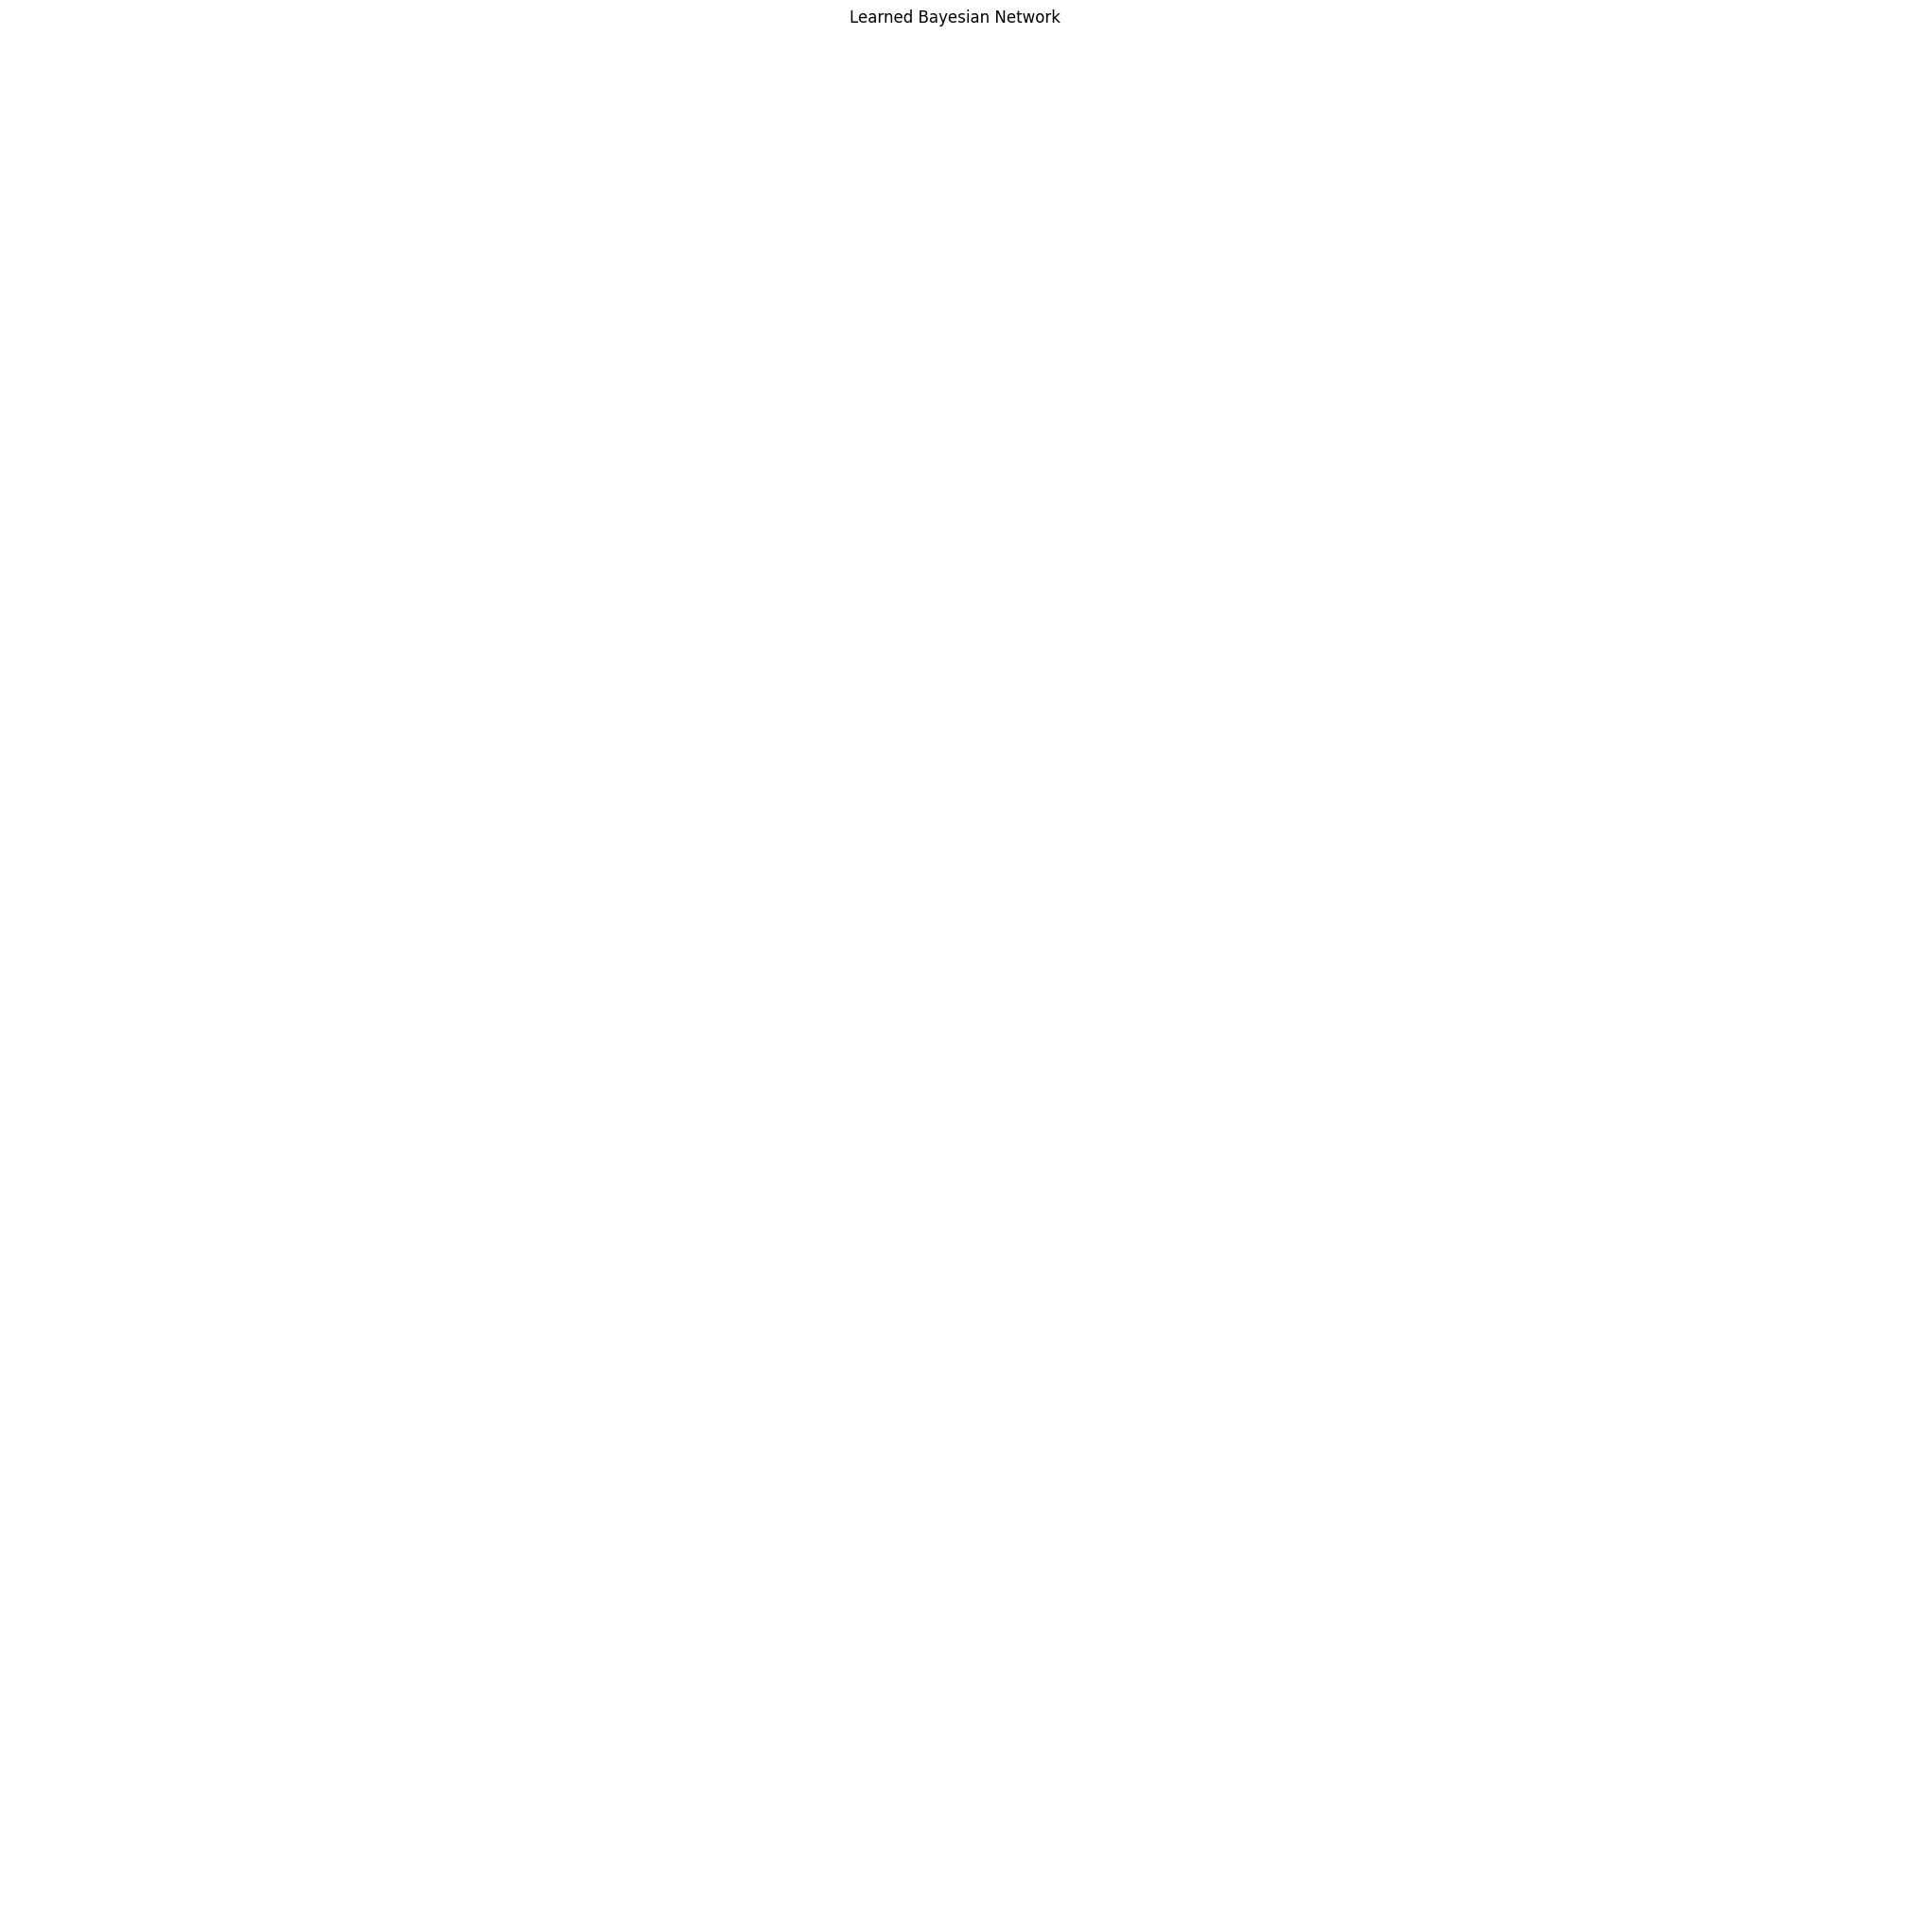

In [4]:
#Random_BN.get_ancestral_graph('int_rate')
nx_graph = nx.DiGraph(Random_BN.get_ancestral_graph('int_rate').edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(20, 20))
nx.draw(nx_graph, pos, with_labels=True, node_size=1000, node_color = 'skyblue', edge_color='#424242',font_size=15,font_color='black')
plt.title('Learned Bayesian Network')
plt.show()


### Inference

In [5]:
def performInference(target_label_list, val_test_data):
    removed_attributes = set()
    y_pred = []
    y_true = []    
    validation_evidence_list = myData.get_evidence_list(val_test_data, target_label_list=target_label_list)
    inference = VariableElimination(Random_BN)
    for i in range(len(validation_evidence_list)):
        for attribute in list(validation_evidence_list[i].keys()):
            if attribute not in Random_BN.nodes():
                removed_attributes.add(attribute)
                del validation_evidence_list[i][attribute]
    print(removed_attributes)            
    for i in range(len(validation_evidence_list)):
        target_variables_result = inference.map_query(target_label_list, evidence = validation_evidence_list[i], show_progress= False) 
        y_pred.append(target_variables_result)
        y_true.append(val_test_data[target_label_list].iloc[i].to_dict())
    
    return y_pred, y_true
  
loan_structure_target_list = ["int_rate","term","installment"]   

for target in loan_structure_target_list:
    if target not in Random_BN.nodes():
        print(target)
        loan_structure_target_list.remove(target)
 
y_pred, y_true = performInference(loan_structure_target_list, validation_data)    


{'annual_inc', 'loan_amnt', 'fico_range_high', 'dti', 'emp_length', 'application_type', 'mort_acc', 'grade', 'last_fico_range_high', 'verification_status', 'tot_cur_bal', 'delinq_2yrs'}


In [6]:
for record in zip(y_pred,y_true):
    print("\nNEW RECORD:\n")
    print("predicted:\n")
    print(record[0])
    print("\nTrue:\n")
    print(record[1])
    print("\n")
    print("#####################")


NEW RECORD:

predicted:

{'term': ' 36 months', 'installment': '(350.054, 692.498]', 'int_rate': '(15.582, 20.718]'}

True:

{'int_rate': '(10.446, 15.582]', 'term': ' 60 months', 'installment': '(350.054, 692.498]'}


#####################

NEW RECORD:

predicted:

{'int_rate': '(15.582, 20.718]', 'installment': '(1034.942, 1377.386]', 'term': ' 36 months'}

True:

{'int_rate': '(10.446, 15.582]', 'term': ' 60 months', 'installment': '(350.054, 692.498]'}


#####################

NEW RECORD:

predicted:

{'int_rate': '(20.718, 25.854]', 'installment': '(1034.942, 1377.386]', 'term': ' 36 months'}

True:

{'int_rate': '(10.446, 15.582]', 'term': ' 36 months', 'installment': '(5.898, 350.054]'}


#####################

NEW RECORD:

predicted:

{'int_rate': '(15.582, 20.718]', 'installment': '(1034.942, 1377.386]', 'term': ' 36 months'}

True:

{'int_rate': '(15.582, 20.718]', 'term': ' 36 months', 'installment': '(5.898, 350.054]'}


#####################

NEW RECORD:

predicted:

{'in

## Testing